In [ ]:
!pip install -U protobuf

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from data_loader.DataGenerator import DataGenerator
import tensorflow as tf
from tensorflow import keras

In [3]:
config = "configs/example.json"
DG = DataGenerator(config=config)
dataset = DG.get_dataset(batch_size=10)

2021-10-26 14:13:20.098691: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
class Unet():
    def __init__(self):
        self.image_size = 256
        self.build_model()
    
    def down_block(self, x, filters, kernel_size=(3, 3), padding="same", strides=1):
        c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
        c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
        p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
        return c, p

    def up_block(self, x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
        us = keras.layers.UpSampling2D((2, 2))(x)
        concat = keras.layers.Concatenate()([us, skip])
        c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
        c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
        return c

    def bottleneck(self, x, filters, kernel_size=(3, 3), padding="same", strides=1):
        c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
        c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
        return c
    
    def build_model(self):
        f = [16, 32, 64, 128, 256]
        inputs = keras.layers.Input((self.image_size, self.image_size, 3))

        p0 = inputs
        c1, p1 = self.down_block(p0, f[0])  # 128 -> 64
        c2, p2 = self.down_block(p1, f[1])  # 64 -> 32
        c3, p3 = self.down_block(p2, f[2])  # 32 -> 16
        c4, p4 = self.down_block(p3, f[3])  # 16->8

        bn = self.bottleneck(p4, f[4])

        u1 = self.up_block(bn, c4, f[3])  # 8 -> 16
        u2 = self.up_block(u1, c3, f[2])  # 16 -> 32
        u3 = self.up_block(u2, c2, f[1])  # 32 -> 64
        u4 = self.up_block(u3, c1, f[0])  # 64 -> 128

        outputs = keras.layers.Conv2D(3, (1, 1), padding="same", activation=None)(u4)
        model = keras.models.Model(inputs, outputs)
        model.compile(optimizer='adam',
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])
        self.model = model

In [19]:
unet = Unet()

In [20]:
unet.model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 256, 256, 16) 448         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 256, 256, 16) 2320        conv2d_38[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 128, 128, 16) 0           conv2d_39[0][0]                  
____________________________________________________________________________________________

In [21]:
item = dataset.as_numpy_iterator().next()
pred = unet.model.predict(item[0])

In [22]:
pred

array([[[[-8.34027864e-03,  1.06035993e-02,  2.23572389e-03],
         [-5.64276939e-04,  1.57969072e-02, -2.86618154e-03],
         [-5.99235529e-03,  1.69824995e-02, -1.23240286e-04],
         ...,
         [-1.07034789e-02,  3.16048712e-02,  2.40658782e-03],
         [-8.01462680e-03,  2.21953578e-02,  2.61991750e-04],
         [-8.32908228e-03,  1.99930072e-02,  6.46713423e-03]],

        [[-4.32814565e-03,  2.00091265e-02, -1.85111840e-03],
         [-1.23331742e-03,  1.58573855e-02, -4.45198780e-03],
         [-9.64612700e-03,  2.02308875e-02,  4.72678104e-03],
         ...,
         [-4.35577612e-03,  2.35628709e-02,  8.48995894e-03],
         [-7.03020021e-03,  1.51117034e-02,  1.24406535e-04],
         [-3.17476317e-03,  2.05639414e-02,  1.64519697e-02]],

        [[ 6.37275446e-03,  2.46300809e-02, -8.96362308e-03],
         [ 1.77207252e-03,  1.74473319e-02, -3.64742638e-03],
         [-4.83334623e-03,  1.86534207e-02, -2.90982844e-03],
         ...,
         [-4.61867079e-0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


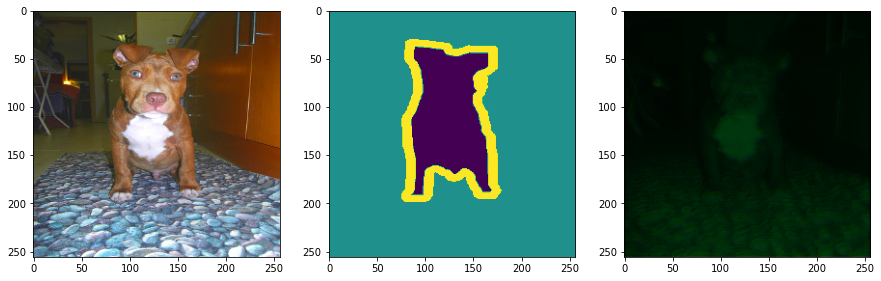

In [23]:
fig, ax = plt.subplots(1,3, figsize=(3*5,5))
ax[0].imshow(item[0][0])
ax[1].imshow(item[1][0])
ax[2].imshow(pred[0])


In [24]:
unet.model.fit(dataset, epochs=1)

 24/739 [..............................] - ETA: 1:28:16 - loss: 0.9810 - accuracy: 0.5888

KeyboardInterrupt: 